-----------
### Download dataset and pre-preocessing via Torchvision for classification task

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# --- handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
# training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
# --- object recognition
"""

  Arg:
    Example: Caltech-101 dataset
    About dataset: The Caltech101 dataset contains images from 101 object categories
    (e.g., “helicopter”, “elephant” and “chair” etc.) and a background category that
    contains the images not from the 101 object categories. For each object category,
    there are about 40 to 800 images, while most classes have about 50 images.
    The resolution of the image is roughly about 300×200 pixels.
    Ref: https://pytorch.org/vision/main/generated/torchvision.datasets.Caltech101.html

"""
train_split = 0.8
training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
train_size = int(train_split * len(training_set))
test_size = len(training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=a3489081-709b-42e9-8e79-336514b95cb2
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:05<00:00, 23.0MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 227MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101
Training set has 6941 instances
Validation set has 1736 instances


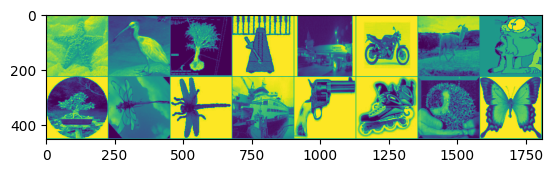

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [4]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

#### Create prievous SOTA model and import pre-trained model from torchvision

ResNet-18

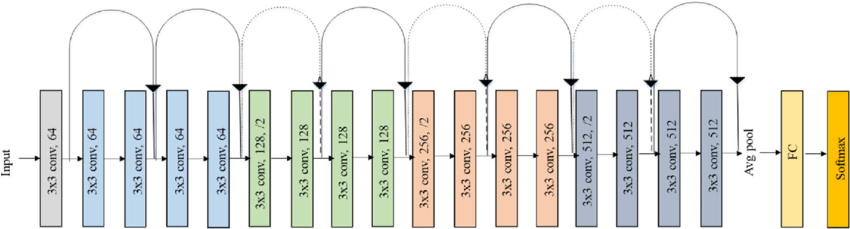

ResNet-34
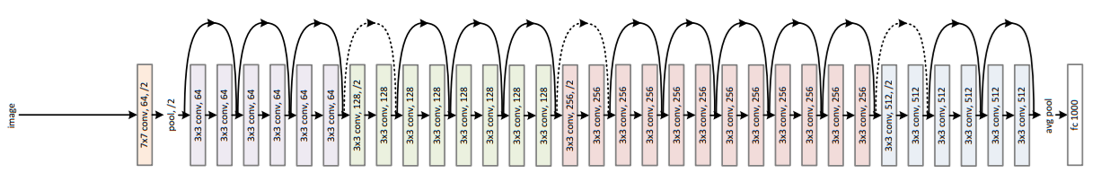

In [5]:
# /////////////////////// ResNet-[18, 34, 50, 101, 152] /////////////////////////////////
# --- From scratch
'''
ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
Web-ref:
    https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Model Selection
def ResNet18(n_C=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=n_C)

def ResNet34(n_C=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_C)

def ResNet50(n_C=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=n_C)

def ResNet101(n_C=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=n_C)

def ResNet152(n_C=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=n_C)

# --- Weights from torch.load
# In case: load saved checkpoint
model_urls = {
     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    #  'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    #  'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    #  'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    #  'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
 }
!pip install wget
import wget
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")





# model and pretrained_weight (if any or required)
model = ResNet50(n_C=101).to(device)
download_n_load_model(model, 'resnet50')






# --- (Optional) Weight and model from Torchvision
resnet = torchvision.models.resnet18(pretrained=True)   # re-define sub-module of resnet as {18, 34, 50, 101, 152}
num_features = list(resnet.children())[-1].in_features
model = nn.Sequential(*list(resnet.children())[:-1],
                      nn.Flatten(),
                      nn.Linear(num_features, 101)
                      ) # throw away old fc layers
print(model)
# /////////////////////////////////////////////////////////////////////////////

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e235863d722998824c77bad6cd2de438bae96ac87d7baaffdc2cae486c53068a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


<ipython-input-5-9ac7c4fe7575>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')
/usr/local/lib/python3.10/dist-packages

load checkpoint...resnet50


100%|██████████| 44.7M/44.7M [00:00<00:00, 66.9MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [6]:
# Model init
model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Hyper-parameter setting

In [7]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_number = 0

EPOCHS = 10
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

In [8]:
t_0_accelerated = time.time()
# count = 0
print(device)
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    # print(len(training_loader))
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        # for inputs, labels in training_loader:
        #   inputs = inputs.to(device)
        #   labels = labels.to(device)

        inputs, labels = data[0].to(device), data[1].to(device)

        # print("Sample labels:", labels)
        # print("Max label value:", labels.max().item())
        # break


        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # print("Output shape:", outputs.shape)
        # print("Labels shape:", labels.shape)
        # print("Labels values:", labels.unique())
        # count += 1
        # print(count)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

cuda
Epochs 1   train loss 2.16679 train acc 0.51390 validate loss 1.63717 validate acc 0.60772
--------------------------------------------------------------------------------
Epochs 2   train loss 1.01000 train acc 0.73246 validate loss 1.01809 validate acc 0.72177
--------------------------------------------------------------------------------
Epochs 3   train loss 0.55483 train acc 0.84570 validate loss 0.79570 validate acc 0.80012
--------------------------------------------------------------------------------
Epochs 4   train loss 0.36185 train acc 0.89195 validate loss 0.85346 validate acc 0.78917
--------------------------------------------------------------------------------
Epochs 5   train loss 0.21188 train acc 0.93747 validate loss 0.77077 validate acc 0.80818
--------------------------------------------------------------------------------
Epochs 6   train loss 0.13263 train acc 0.96254 validate loss 0.92947 validate acc 0.78744
--------------------------------------------

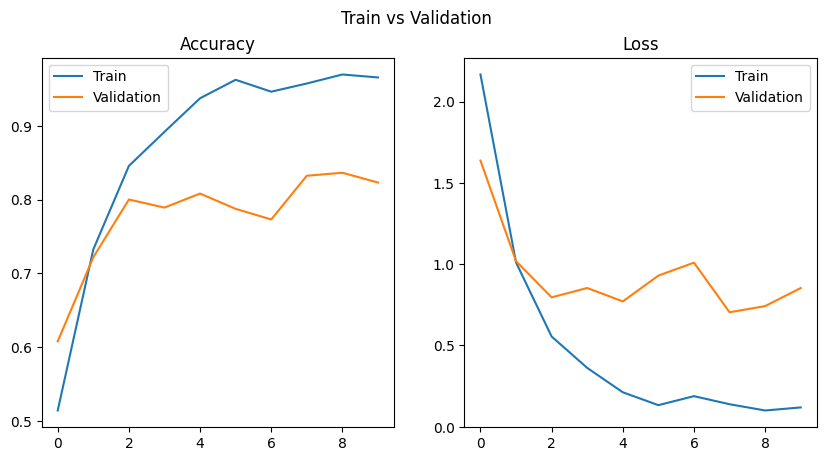

In [9]:
plot_graph(training_logs)

In [10]:
# Inference phase
PATH = './cp/best_pretrainedmodel.pth'
# loaded_model = customhandwrittenmodel().to(device)
# loaded_model = model.to(device)
# loaded_model.load_state_dict(torch.load(PATH))
loaded_model = model
loaded_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
# stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
stored_lbs = torch.empty(0, dtype=torch.float32).to(device)
stored_preds = torch.empty(0, dtype=torch.float32).to(device)
with torch.no_grad(): # Context manager to disable gradient calculation
    for i, tdata in enumerate(validation_loader):
        tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
        toutputs = loaded_model(tinputs)
        loss = loss_fn(toutputs, tlabels)
        test_loss += loss
        # Argmax one-hot pred to class vector
        _, preds_t = torch.max(toutputs, 1)
        acc_test += (preds_t == tlabels).float().mean().item()
        # store vec
        stored_lbs = torch.cat((stored_lbs, tlabels), 0)
        stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-10-79ea2a5c0678>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))


[(pretraining || test loss: 0.7039791345596313] [accuracy_test: 83.26 %]


In [11]:
# Inference phase
PATH = './cp/best_pretrainedmodel.pth'
# loaded_model = customhandwrittenmodel().to(device)
loaded_model = model.to(device)
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
# stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
stored_lbs = torch.empty(0, dtype=torch.float32).to(device)
stored_preds = torch.empty(0, dtype=torch.float32).to(device)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

<ipython-input-11-c9ed2a1214ab>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(PATH))


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 2483 has 14.74 GiB memory in use. Of the allocated memory 14.58 GiB is allocated by PyTorch, and 21.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Additional Quantitative Matrics

In [12]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

Precision/Recall/F-beta score: (0.8717500071852753, 0.8422619047619048, 0.8384168453519573, None)
NMI score: 0.9065932202228006, RI score: 0.9018765167170848


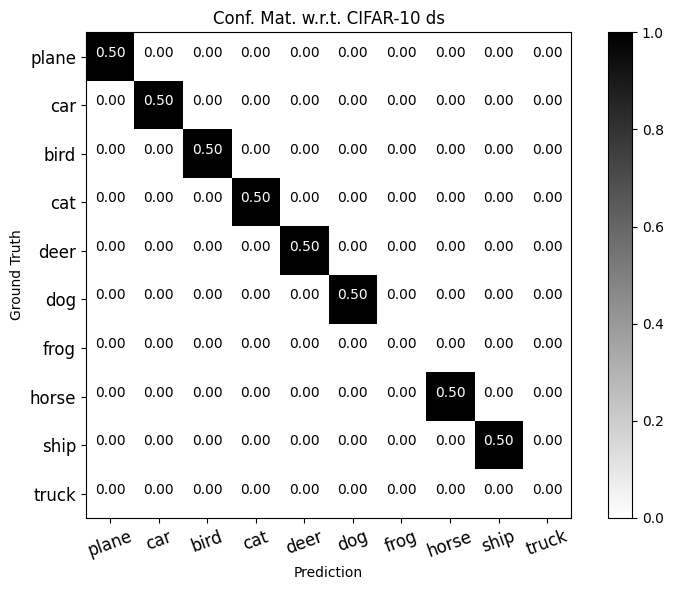

In [13]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

### Summary
There are a lot of pretrained SOTA network not mentioned, such as EfficientNet, SqueezeNet, Inception, Xception, Wide ResNet, ResNeXt, MNASNet, GoogLeNet, and so on. This is just the basic of the usage of previous SOTA model and its pretrained weights to resume or fine-tune training. You can more discover the other or the recent SOTA model derived by torchvision (https://pytorch.org/vision/stable/models.html)

--------------------
### Homework

ใช้ previous SOTA model and pretrained weights

*   ResNet18
*   ResNet50
*   VGG16
*   MobileNetV3-large
*   MobileNetV3-small

ทำการเปลี่ยนหัวคัดแยกใหม่ (Clssifier head) เพื่อใช้กับ Caltech101 dataset โดยใช้ hyper-parameter setting แบบเดียวกัน (e.g., batch size, epoch>=10, learning rate, optimizer, etc.) เพื่อทำการเปรียบเทียบ (Benchmarking) และทำการฝึกฝนบน GPU/TPU setting (either one)
\
\
1.) เปรียบเทียบ parameter and resource usage\
2.) เปรียบเทียบ performance (quantitative and visualization results)\
3.) เปรียบเทียบ time consumption ในการ training\
\
จัดทำเป็น PDF ส่ง